
## Метод опорных векторов и аппроксимация ядер


In [ ]:
%load_ext autoreload
%autoreload 2

Данные -Fashion MNIST

In [ ]:
import numpy as np

# 1 Способ
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.utils.validation import check_X_y

class RandomFeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, func=np.cos):
        self.n_features = n_features
        self.new_dim = new_dim
        self.func = func
        self.sigma2 = None
        self.w = None
        self.b = None

    def fit(self, X, y=None):
        X = X.copy()
        n_samples = X.shape[0]
        max_pairs = 10**6
        subset_size = int(np.sqrt(2 * max_pairs)) + 1
        subset_size = min(subset_size, n_samples)
        indices = np.random.choice(n_samples, size=subset_size, replace=False)
        X_subset = X[indices]

        diff = X_subset[:, None, :] - X_subset[None, :, :]
        squared_dist = np.sum(diff**2, axis=-1)
        triu_indices = np.triu_indices_from(squared_dist, k=1)
        distances = squared_dist[triu_indices]
        self.sigma2 = np.median(distances)

        d = X.shape[1]
        self.w = np.random.normal(loc=0, scale=np.sqrt(1/self.sigma2), size=(self.n_features, d))
        self.b = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features)
        return self

    def transform(self, X, y=None):
        projections = np.dot(X, self.w.T) + self.b
        return self.func(projections)

class RFFPipeline(BaseEstimator):
    def __init__(
        self,
        n_features=1000,
        new_dim=50,
        use_PCA=True,
        feature_creator_class=RandomFeatureCreator,
        classifier_class=LogisticRegression,
        classifier_params=None,
    ):
        self.n_features = n_features
        self.new_dim = new_dim
        self.use_PCA = use_PCA
        self.feature_creator_class = feature_creator_class
        self.classifier_class = classifier_class
        self.classifier_params = classifier_params or {}
        self.pipeline = None

    def fit(self, X, y):
        pipeline_steps = []
        if self.use_PCA:
            pipeline_steps.append(('pca', PCA(n_components=self.new_dim)))
        pipeline_steps.append(('rff', self.feature_creator_class(n_features=self.n_features)))
        pipeline_steps.append(('clf', self.classifier_class(**self.classifier_params)))
        self.pipeline = Pipeline(pipeline_steps)
        self.pipeline.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)

    def predict(self, X):
        return self.pipeline.predict(X)

import keras
from keras.datasets import fashion_mnist

(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(-1, 28*28) / 255.0
x_test = x_test_pics.reshape(-1, 28*28) / 255.0

pipeline = RFFPipeline(
    classifier_params={'max_iter': 200, 'random_state': 42, 'multi_class': 'ovr', 'solver': 'lbfgs'}
)
pipeline.fit(x_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность: {accuracy:.4f}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Точность: 0.8762


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

start_time = time.time()
linear_svm = SVC(kernel='linear', random_state=42)
linear_svm.fit(x_train, y_train)
y_pred_linear_svm = linear_svm.predict(x_test)
linear_svm_accuracy = accuracy_score(y_test, y_pred_linear_svm)
linear_svm_time = time.time() - start_time

print(f'Линейный SVM: Точность = {linear_svm_accuracy:.4f}, Время обучения = {linear_svm_time:.2f} сек')

Линейный SVM: Точность = 0.8464, Время обучения = 621.16 сек


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import time

start_time = time.time()
linear_svm = LinearSVC(random_state=42, max_iter=1000)
linear_svm.fit(x_train, y_train)
y_pred_linear_svm = linear_svm.predict(x_test)
linear_svm_accuracy = accuracy_score(y_test, y_pred_linear_svm)
linear_svm_time = time.time() - start_time

print(f'LinearSVC: Точность = {linear_svm_accuracy:.4f}, Время обучения = {linear_svm_time:.2f} сек')

LinearSVC: Точность = 0.8402, Время обучения = 145.76 сек


In [ ]:

subset_size = 10000
indices = np.random.choice(len(x_train), subset_size, replace=False)
x_train_subset = x_train[indices]
y_train_subset = y_train[indices]

start_time = time.time()
rbf_svm = SVC(kernel='rbf', random_state=42)
rbf_svm.fit(x_train_subset, y_train_subset)
y_pred_rbf_svm = rbf_svm.predict(x_test)
rbf_svm_accuracy = accuracy_score(y_test, y_pred_rbf_svm)
rbf_svm_time = time.time() - start_time

print(f'Ядровой SVM (RBF): Точность = {rbf_svm_accuracy:.4f}, Время обучения = {rbf_svm_time:.2f} сек')

Ядровой SVM (RBF): Точность = 0.8524, Время обучения = 60.56 сек


In [ ]:
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier

pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

start_time = time.time()
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(x_train_pca, y_train)
y_pred_lgbm = lgbm.predict(x_test_pca)
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_time = time.time() - start_time

print(f'LightGBM с PCA: Точность = {lgbm_accuracy:.4f}, Время обучения = {lgbm_time:.2f} сек')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 50
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM с PCA: Точность = 0.8684, Время обучения = 30.53 сек


In [ ]:

start_time = time.time()
pipeline = RFFPipeline(
    classifier_params={'max_iter': 200, 'random_state': 42, 'multi_class': 'ovr', 'solver': 'lbfgs'}
)
pipeline.fit(x_train, y_train)
y_pred_rff = pipeline.predict(x_test)
rff_accuracy = accuracy_score(y_test, y_pred_rff)
rff_time = time.time() - start_time

print(f'RFF: Точность = {rff_accuracy:.4f}, Время обучения = {rff_time:.2f} сек')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFF: Точность = 0.8746, Время обучения = 213.39 сек


Таким образом, получилось:


**Линейный SVM**	 - Долго обучается, качество  невысокое. LinearSVC — быстрее, но ещё ниже точность.

**Ядерный SVM** на 10k объектов - 	Лучше линейного SVM, но приходится урезать выборку, иначе обучение займет слишком много времени.

**LightGBM + PCA** - Очень быстрая модель с хорошей точностью, удачный компромисс между скоростью и качеством.

**RFF + Logistic Regression**	- Самое высокое качество среди моделей, но обучается медленнее, чем бустинг.




Эксперименты:
1.  PCA
2.  n_features
3.  логист или SVM

In [7]:
import time
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.utils.validation import check_X_y
from scipy.sparse import csr_matrix

class RandomFeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, func=np.cos):
        self.n_features = n_features
        self.new_dim = new_dim
        self.func = func
        self.sigma2 = None
        self.w = None
        self.b = None

    def fit(self, X, y=None):
        X = X.copy()
        n_samples = X.shape[0]
        max_pairs = 10**6
        subset_size = int(np.sqrt(2 * max_pairs)) + 1
        subset_size = min(subset_size, n_samples)
        indices = np.random.choice(n_samples, size=subset_size, replace=False)
        X_subset = X[indices]

        diff = X_subset[:, None, :] - X_subset[None, :, :]
        squared_dist = np.sum(diff**2, axis=-1)
        triu_indices = np.triu_indices_from(squared_dist, k=1)
        distances = squared_dist[triu_indices]
        self.sigma2 = np.median(distances)

        d = X.shape[1]
        self.w = np.random.normal(loc=0, scale=np.sqrt(1/self.sigma2), size=(self.n_features, d))
        self.b = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features)
        return self

    def transform(self, X, y=None):
        projections = np.dot(X, self.w.T) + self.b
        return self.func(projections)

class RFFPipeline(BaseEstimator):
    def __init__(
        self,
        n_features=1000,
        new_dim=50,
        use_PCA=True,
        feature_creator_class=RandomFeatureCreator,
        classifier_class=LogisticRegression,
        classifier_params=None,
    ):
        self.n_features = n_features
        self.new_dim = new_dim
        self.use_PCA = use_PCA
        self.feature_creator_class = feature_creator_class
        self.classifier_class = classifier_class
        self.classifier_params = classifier_params or {}
        self.pipeline = None

    def fit(self, X, y):
        pipeline_steps = []
        if self.use_PCA:
            pipeline_steps.append(('pca', PCA(n_components=self.new_dim)))
        pipeline_steps.append(('rff', self.feature_creator_class(n_features=self.n_features)))
        pipeline_steps.append(('clf', self.classifier_class(**self.classifier_params)))
        self.pipeline = Pipeline(pipeline_steps)
        self.pipeline.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)

    def predict(self, X):
        return self.pipeline.predict(X)

import keras
from keras.datasets import fashion_mnist

(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(-1, 28*28) / 255.0
x_test = x_test_pics.reshape(-1, 28*28) / 255.0

In [ ]:
# С PCA
pipeline = RFFPipeline(
    use_PCA=True,
    classifier_class=LogisticRegression,
    classifier_params={'max_iter': 200, 'random_state': 42}
)
start_time = time.time()
pipeline.fit(x_train, y_train)
y_pred_pca = pipeline.predict(x_test)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
time_pca = time.time() - start_time
print(f'С PCA: Точность = {accuracy_pca:.4f}, Время обучения = {time_pca:.2f} сек')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


С PCA: Точность = 0.8664, Время обучения = 124.06 сек


In [ ]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

subset_size = 1000
indices = np.random.choice(len(x_train), subset_size, replace=False)
x_train_subset = x_train[indices]
y_train_subset = y_train[indices]

# Без PCA только на подмножестве
pipeline_no_pca = RFFPipeline(
    use_PCA=False,
    n_features=1000,
    classifier_class=LogisticRegression,
    classifier_params={'max_iter': 200, 'random_state': 42}
)
start_time = time.time()
# import psutil

# print(f'Использование памяти перед fit: {psutil.virtual_memory().available / (1024 ** 3):.2f} ГБ')
pipeline_no_pca.fit(x_train_subset, y_train_subset)
# print(f'Использование памяти после fit: {psutil.virtual_memory().available / (1024 ** 3):.2f} ГБ')

y_pred_no_pca = pipeline_no_pca.predict(x_test)
accuracy_no_pca = accuracy_score(y_test, y_pred_no_pca)
time_no_pca = time.time() - start_time
print(f'Без PCA: Точность = {accuracy_no_pca:.4f}, Время обучения = {time_no_pca:.2f} сек')

Без PCA: Точность = 0.7958, Время обучения = 6.53 сек


Без PCA модель не работала на полном наборе данных из-за вычислительной сложности. Пришлось обучать на ограниченном подмножестве, с РСА, который снижал размерность данных таких трудностей не возникло. Качество  с РСА тоже выше.

In [ ]:
import matplotlib.pyplot as plt


n_features_values = [10, 50, 100, 200, 500, 1000, 1500, 2000]
accuracies = []

for n_feat in n_features_values:
    model = RFFPipeline(n_features=n_feat, classifier_class=LogisticRegression, classifier_params={'max_iter': 1000, 'random_state': 42})

    start_time = time.time()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"n_features = {n_feat}, Точность = {acc:.4f},  Время обучения = {time.time() - start_time:.2f} сек")


n_features = 10, Точность = 0.6127,  Время обучения = 7.11 сек
n_features = 50, Точность = 0.8147,  Время обучения = 18.96 сек
n_features = 100, Точность = 0.8402,  Время обучения = 38.89 сек
n_features = 200, Точность = 0.8558,  Время обучения = 49.21 сек
n_features = 500, Точность = 0.8726,  Время обучения = 165.26 сек


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


n_features = 1000, Точность = 0.8767,  Время обучения = 482.83 сек


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


n_features = 1500, Точность = 0.8784,  Время обучения = 640.75 сек


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


n_features = 2000, Точность = 0.8836,  Время обучения = 940.33 сек


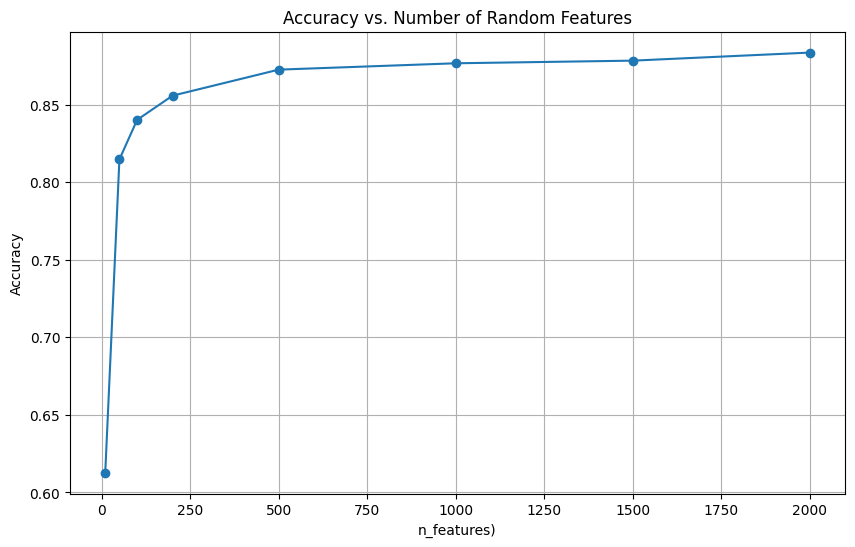

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(n_features_values, accuracies, marker='o', linestyle='-')
plt.xlabel("n_features)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Random Features")

plt.grid(True)
plt.show()


Точность модели увеличивается с ростом числа признаков, но начиная с n_features = 500, прирост точности становится незначительным (выходит на плато), но значительно увеличивается время обучения.

In [ ]:

rff_svm = RFFPipeline(n_features=200, classifier_class=SVC, classifier_params={"kernel": "linear", "random_state": 42})

start_time = time.time()
rff_svm.fit(x_train, y_train)
svm_time = time.time() - start_time

y_pred_svm = rff_svm.predict(x_test)


accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm:.4f},  Время обучения: {svm_time:.2f} сек")

SVM Accuracy: 0.8640,  Время обучения: 94.85 сек


При логистической регрессии было:
n_features = 200, Точность = 0.8558,  Время обучения = 49.21 сек

In [ ]:

rff_svm = RFFPipeline(n_features=500, classifier_class=SVC, classifier_params={"kernel": "linear", "random_state": 42})

start_time = time.time()
rff_svm.fit(x_train, y_train)
svm_time = time.time() - start_time

y_pred_svm = rff_svm.predict(x_test)


accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm:.4f},  Время обучения: {svm_time:.2f} сек")

SVM Accuracy: 0.8755,  Время обучения: 234.13 сек


При логистической регрессии было: n_features = 500, Точность = 0.8726,  Время обучения = 165.26 сек


Таким образом, логистическая регрессия рабртает быстрее, но немного уступает в качестве

**ORF**

In [8]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.linalg import hadamard
from keras.datasets import fashion_mnist

class CorrectORF(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, gamma=None):
        self.n_features = n_features
        self.gamma = gamma
    def fit(self, X, y=None):
        if self.gamma is None:
            n_samples = X.shape[0]
            subset_size = min(1000, n_samples)
            X_subset = X[np.random.choice(n_samples, subset_size, replace=False)]

            dists = np.sum((X_subset[:, None, :] - X_subset[None, :, :])**2, axis=2)
            self.gamma = 1.0 / np.median(dists[np.triu_indices_from(dists, k=1)])

        d = X.shape[1]
        self.W_ = self._generate_orthogonal_weights(d)
        self.b_ = np.random.uniform(0, 2*np.pi, size=self.n_features)
        return self

    def _generate_orthogonal_weights(self, d):
        n_blocks = int(np.ceil(self.n_features / d))
        blocks = []

        for _ in range(n_blocks):
            H = hadamard(d)
            D1 = np.diag(np.random.choice([-1,1], d))
            D2 = np.diag(np.random.choice([-1,1], d))
            D3 = np.diag(np.random.choice([-1,1], d))

            W_block = H @ D1 @ D2 @ D3
            blocks.append(W_block.T)

        W = np.vstack(blocks)[:self.n_features, :]
        return W * np.sqrt(2 * self.gamma)
    def transform(self, X):
        proj = X @ self.W_.T
        return np.sqrt(2.0 / self.n_features) * np.cos(proj + self.b_)

n_features = 1000
power_of_two_dim = 512


orf_pipe = Pipeline([
    ('pca', PCA(n_components=power_of_two_dim)),
    ('orf', CorrectORF(n_features=n_features)),
    ('clf', LogisticRegression(max_iter=500))
])

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 784)[:10000]/255.0
y_train = y_train[:10000]

orf_pipe.fit(x_train, y_train)
orf_acc = accuracy_score(y_test, orf_pipe.predict(x_test.reshape(-1, 784)/255.0))

print(f"Correct ORF Accuracy: {orf_acc:.4f}")

Correct ORF Accuracy: 0.8228


Точность ORF получилась ниже RFF



___Выведите градиент:___



$$
\frac{1}{2} \| K w - y \|^2 = \frac{1}{2} (K w - y)^T (K w - y).
$$
дифференцируем по \( w \):
$$
\nabla_w \left( \frac{1}{2} \| K w - y \|^2 \right) = K^T (K w - y).
$$
 \( K^T = K \), тк К симметрична
$$
\nabla_w \left( \frac{1}{2} \| K w - y \|^2 \right) = K (K w - y).
$$


$$
\frac{\lambda}{2} w^T K w.
$$

$$
\nabla_w \left( \frac{\lambda}{2} w^T K w \right) = \lambda K w.
$$

Итоговый градиент:
$$
\nabla_w Q(w) = K (K w - y) + \lambda K w.
$$

### Вывод градиента с учётом свободного коэффициента \( b \)

Функция потерь с \( b \):
$$
Q(w, b) = \frac{1}{2} \| K w + b \mathbf{1} - y \|^2 + \frac{\lambda}{2} w^T K w.
$$

Градиент по \( w \):

$$
\nabla_w \left( \frac{1}{2} \| K w + b \mathbf{1} - y \|^2 \right) = K (K w + b \mathbf{1} - y).
$$


Градиент по \( b \):

$$
\frac{\partial}{\partial b} \left( \frac{1}{2} \| K w + b \mathbf{1} - y \|^2 \right) = \mathbf{1}^T (K w + b \mathbf{1} - y).
$$

ИТОГ

Без свободного коэффициента:
$$
\nabla_w Q(w)
=
K (K w - y)
+
\lambda K w.
$$

С учетом свободного коэффициента b:

$$
\begin{aligned}
\nabla_w Q(w,b)
&=
K (K w + b\,\mathbf{1} - y) + \lambda K w, \\[6pt]
\frac{\partial Q(w,b)}{\partial b}
&=
\mathbf{1}^\top (K w + b\,\mathbf{1} - y).
\end{aligned}
$$

